In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df_path = "../../data/raw/debunking_review.tsv"
df = pd.read_csv(df_path, sep="\t")

In [3]:
from eppi_text_classification import (
    get_features_and_labels,
    get_tfidf_and_names,
)

word_features, labels = get_features_and_labels(df)

tfidf_scores, feature_names = get_tfidf_and_names(word_features)

In [ ]:
from eppi_text_classification import OptunaHyperparameterOptimisation
from eppi_text_classification.utils import delete_optuna_study

optimiser = OptunaHyperparameterOptimisation(
    tfidf_scores,
    labels,
    "LGBMClassifier",
    n_trials_per_job=10,
    n_jobs=-1,
    nfolds=3,
    num_cv_repeats=1,
)

delete_optuna_study("lgbm_binary")
best_params = optimiser.optimise_hyperparameters(study_name="lgbm_binary")

In [4]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

# model = LGBMClassifier(**best_params)

model = LGBMClassifier(
    verbosity=-1,
    boosting_type="gbdt",
    max_depth=4,
    min_child_samples=30,
    learning_rate=0.1245928917280467,
    num_leaves=6,
    n_estimators=2455,
    subsample_for_bin=20000,
    subsample=1.0,
    objective="binary",
    scale_pos_weight=27,
    min_split_gain=2.52381000405986e-06,
    min_child_weight=5.544840854157574e-06,
    reg_alpha=3.629909607712911e-05,
    reg_lambda=3.671749546766942e-05,
)

X_train, X_test, y_train, y_test = train_test_split(
    tfidf_scores, labels, test_size=0.333, stratify=labels, random_state=7
)

model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.1245928917280467, max_depth=4,
               min_child_samples=30, min_child_weight=5.544840854157574e-06,
               min_split_gain=2.52381000405986e-06, n_estimators=2455,
               num_leaves=6, objective='binary',
               reg_alpha=3.629909607712911e-05,
               reg_lambda=3.671749546766942e-05, scale_pos_weight=27,
               subsample_for_bin=20000, verbosity=-1)

In [5]:
from eppi_text_classification.predict import (
    get_threshold,
    threshold_predict,
)


threshold = get_threshold(model, X_test, y_test, target_tpr=1)

y_test_pred = threshold_predict(model, X_test, threshold)
y_train_pred = threshold_predict(model, X_train, threshold)

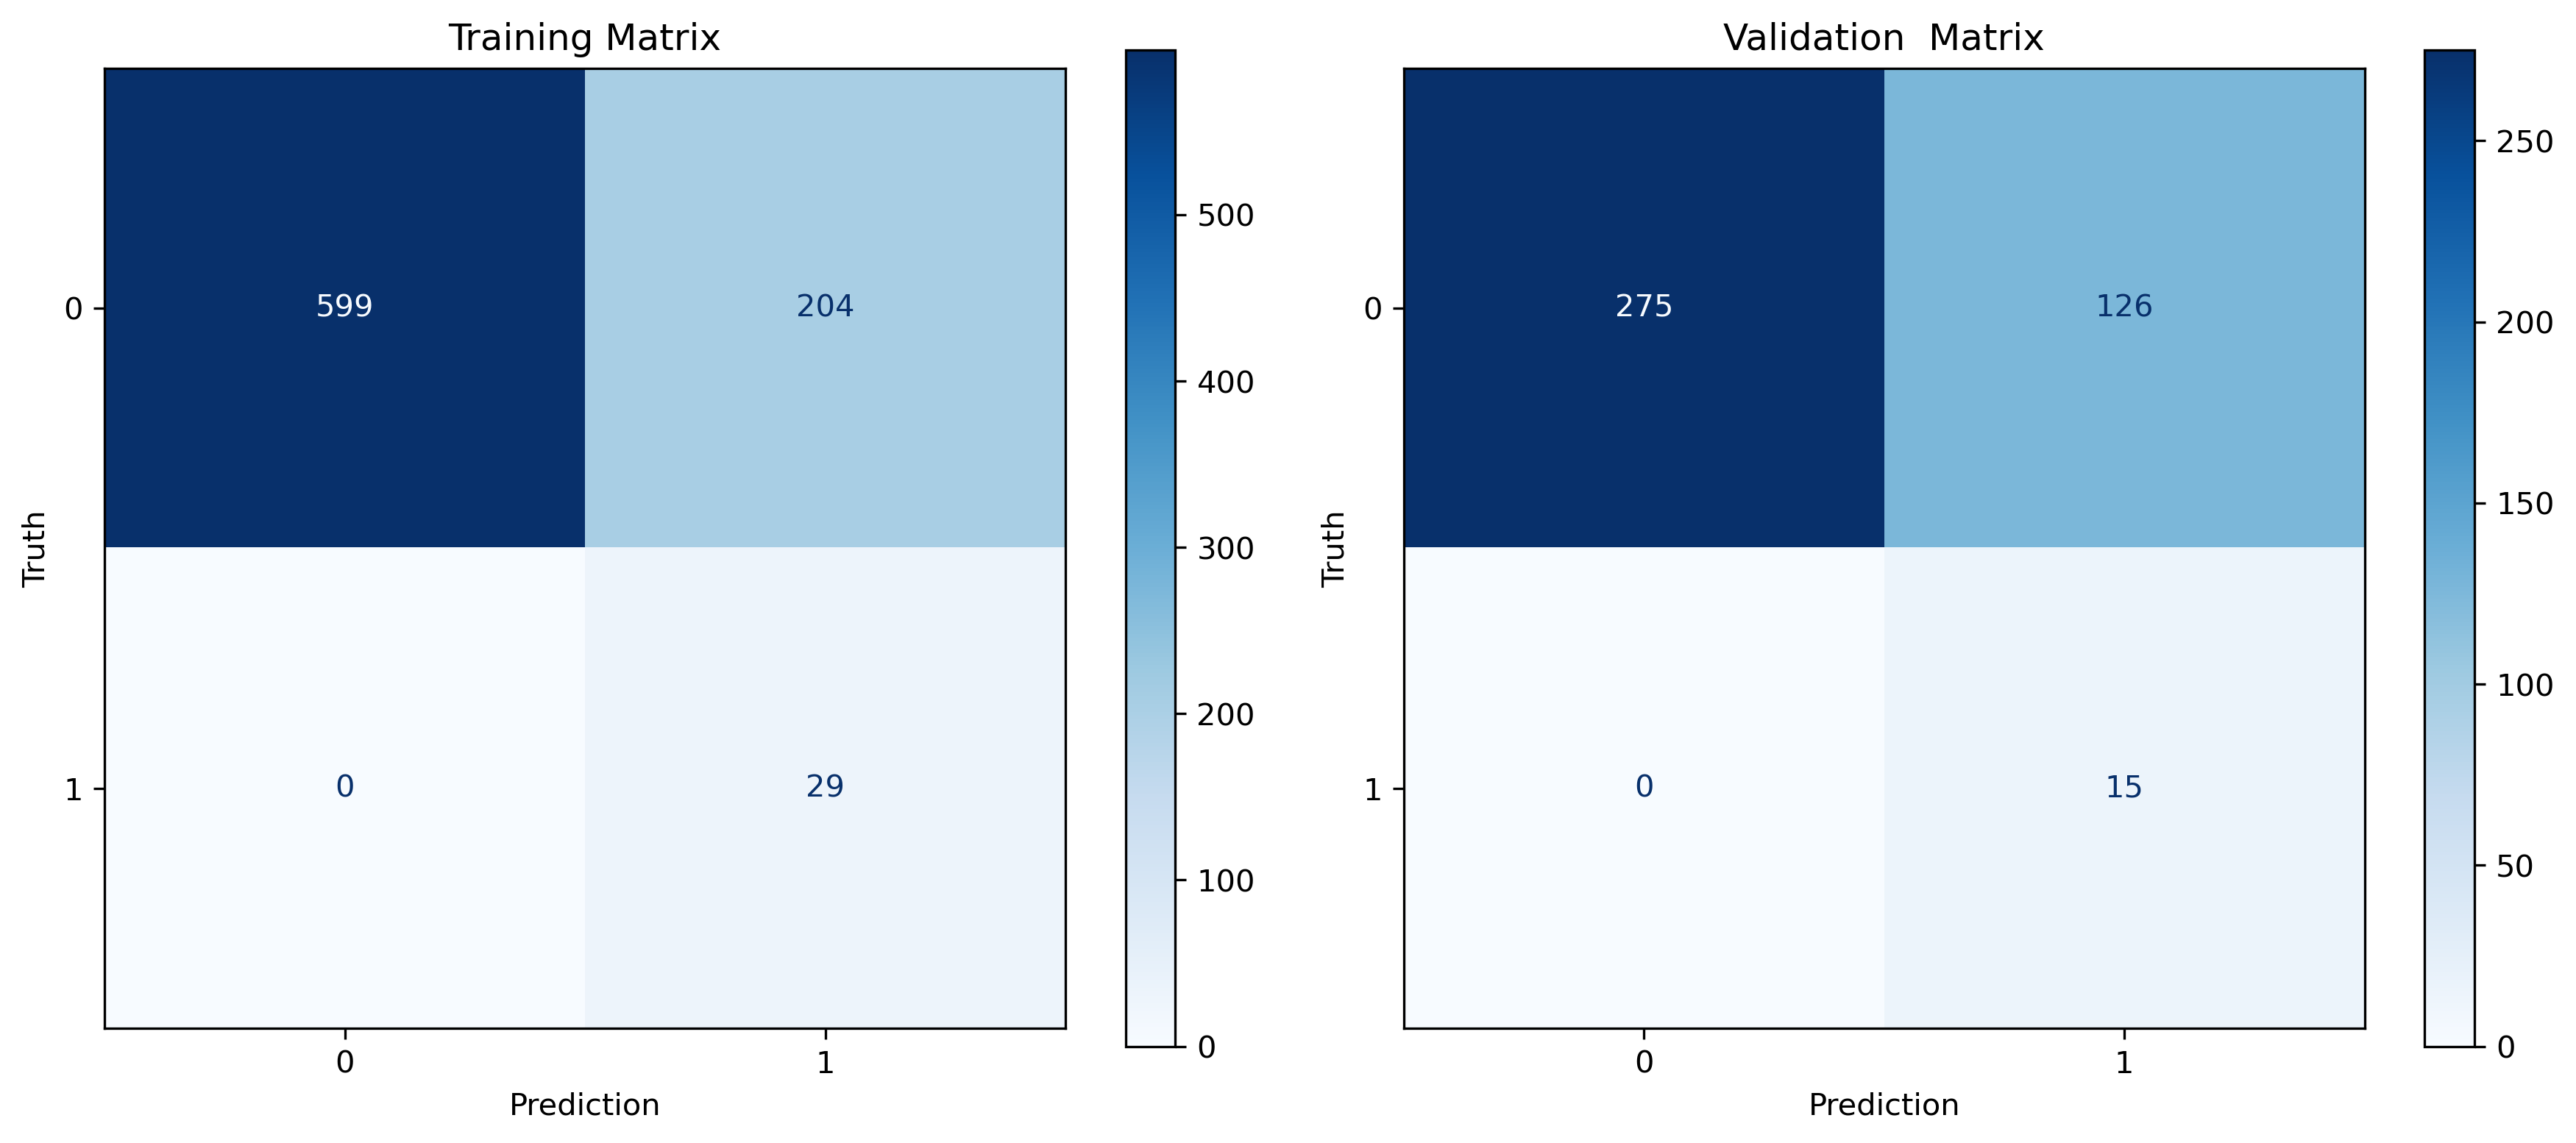

In [7]:
from eppi_text_classification.plots import binary_train_valid_confusion_plot

binary_train_valid_confusion_plot(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
)

In [8]:
from eppi_text_classification import binary_train_valid_confusion_plotly

binary_train_valid_confusion_plotly(
    y_train,
    y_train_pred,
    y_test,
    y_test_pred,
    postive_label="Included",
    negative_label="Excluded",
)

In [9]:
from eppi_text_classification.predict import predict_probabilities
from eppi_text_classification.plotly_roc import plotly_roc

y_test_pred_probs = predict_probabilities(model, X_test)
plotly_roc(y_test, y_test_pred_probs)

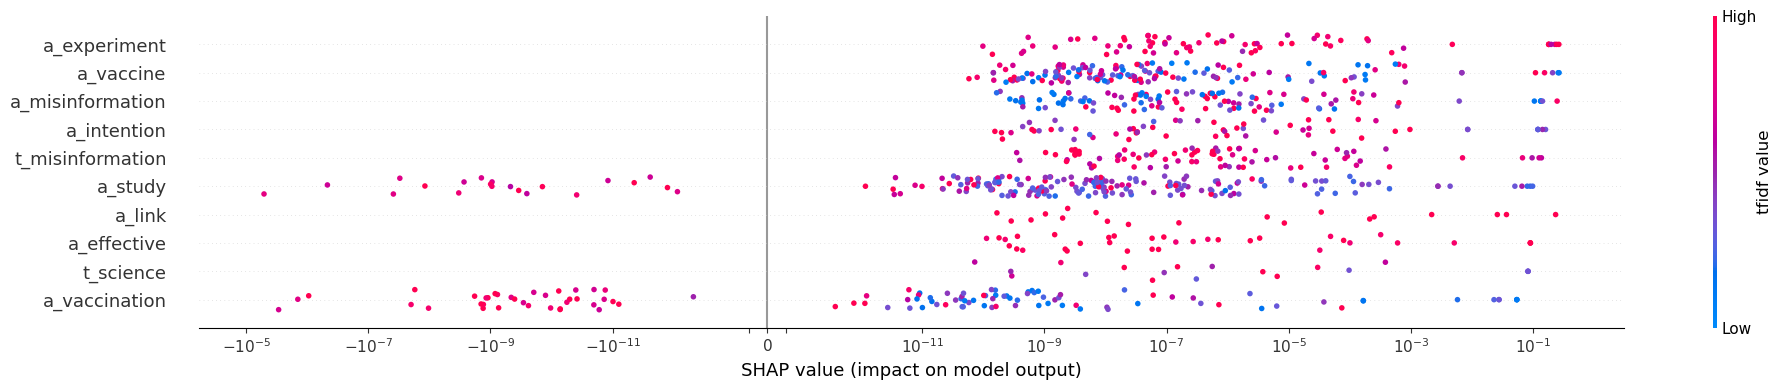

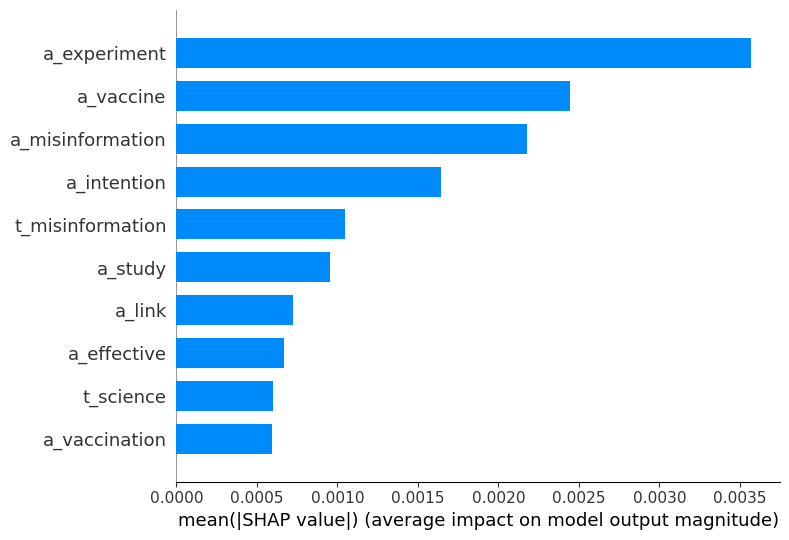

In [36]:
from eppi_text_classification.shap_plotter import ShapPlotter

shap_plotter = ShapPlotter(model, X_test, feature_names)

shap_plotter.dot_plot(num_display=10)
shap_plotter.bar_chart()

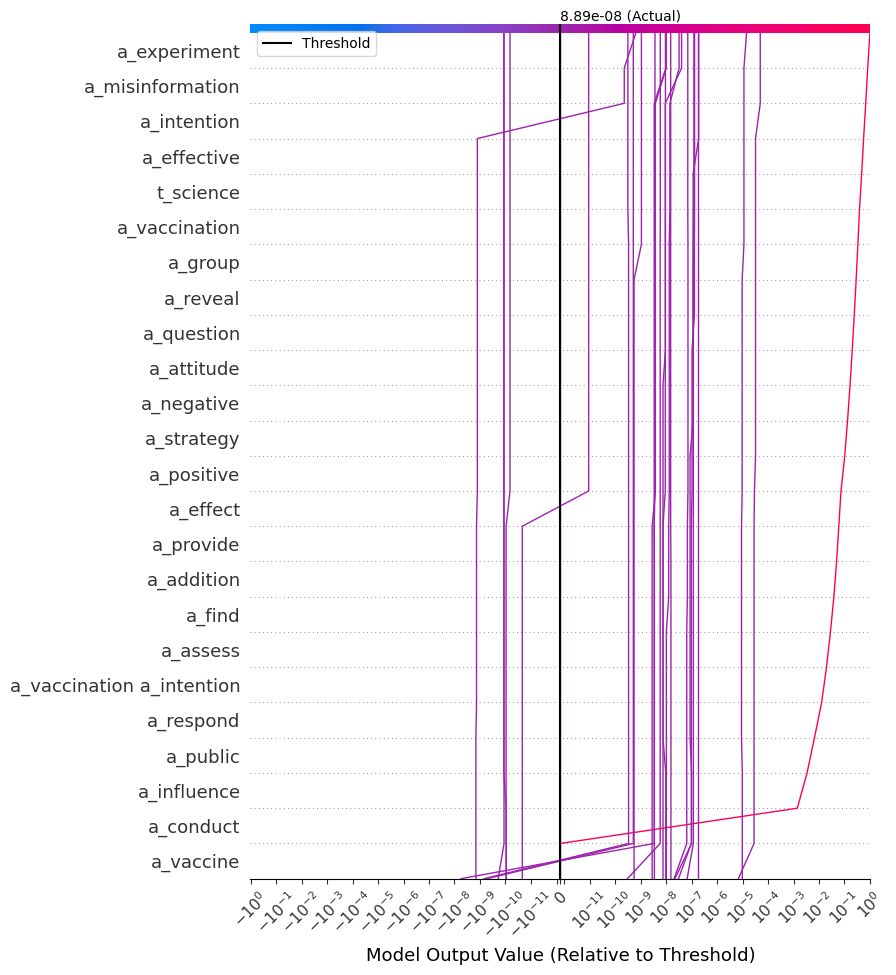

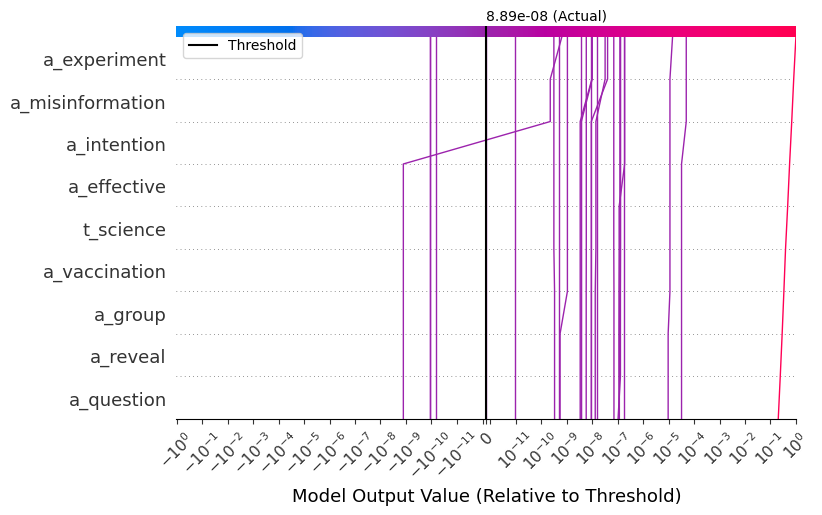

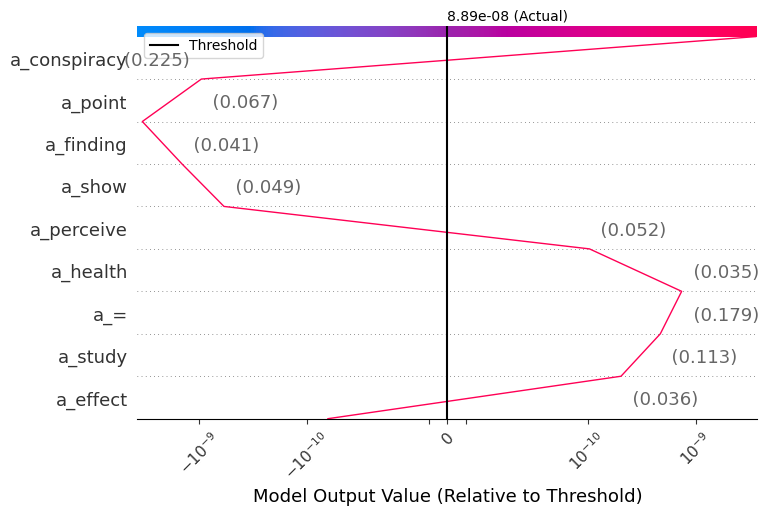

In [41]:
shap_plotter = ShapPlotter(model, X_test[:25], feature_names)

shap_plotter.decision_plot(threshold=threshold, num_display=25)
shap_plotter.decision_plot(threshold=threshold, num_display=10)
shap_plotter.single_decision_plot(threshold=threshold, index=0, num_display=10)